### 1. Importação das Bibliotecas e Configuração

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURAÇÃO DOS CAMINHOS ---
RESULTS_PATH = 'results/TODOS_OS_RESULTADOS_CONSOLIDADOS.csv'
OUTPUT_DIR = 'results/final_analysis'

# Garante que o diretório de saída existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Bibliotecas importadas e configuração concluída.")

Bibliotecas importadas e configuração concluída.


### 2. Carregamento e Preparação dos Dados

Nesta etapa, carregamos o arquivo CSV consolidado, convertemos as unidades para formatos mais legíveis (segundos e megabytes) e adicionamos descrições textuais para cada experimento, facilitando a interpretação das tabelas e gráficos.

In [10]:
def load_and_prepare_data(path=RESULTS_PATH):
    """
    Carrega os dados, converte para unidades legíveis e adiciona
    descrições para os experimentos.
    """
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        print(f"ERRO: Arquivo de resultados não encontrado em '{path}'")
        return None

    # Conversão de unidades para facilitar a análise
    df['DURACAO_SEGUNDOS'] = df['TOTAL_ELAPSED_TIME'] / 1000
    df['BYTES_LIDOS_MB'] = df['BYTES_SCANNED'] / (1024 * 1024)
    
    # Mapeamento de descrições para os experimentos
    exp_descriptions = {
        'E1': '1. Logradouros por Cidade',
        'E2': '2. Cidades por Estado',
        'E3': '3. Estados por Região',
        'E4': '4. Logradouros por Cidade e Estado',
        'E5': '5. Cidades por Estado e Região',
        'E6': '6. Logradouros por Cid, Est e Região'
    }
    df['Descricao'] = df['EXPERIMENTO_ID'].map(exp_descriptions)
    
    print("Dados carregados e preparados com sucesso.")
    return df

# Executa a função e exibe as 5 primeiras linhas para verificação
df_dados = load_and_prepare_data()
if df_dados is not None:
    df_dados.head()

Dados carregados e preparados com sucesso.


### 3. Análise e Criação da Tabela Resumo

Com os dados preparados, agora agregamos os resultados calculando a média de todas as repetições (60 por experimento). Em seguida, pivotamos a tabela para comparar os cenários `normalizado` e `desnormalizado` lado a lado. Por fim, calculamos as métricas de ganho mais importantes: `Speedup_Factor` (quantas vezes mais rápido) e `IO_Reduction_Factor` (quantas vezes menos dados foram lidos).

In [11]:
def create_summary_table(df):
    """
    Agrega os dados calculando a média e cria uma tabela comparativa
    final com métricas de speedup e eficiência de I/O.
    """
    # Agrega os dados pela média, pois temos múltiplas execuções
    summary = df.groupby(['Descricao', 'CENARIO']).agg(
        Tempo_Medio_s=('DURACAO_SEGUNDOS', 'mean'),
        Bytes_Lidos_Medio_MB=('BYTES_LIDOS_MB', 'mean')
    ).reset_index()
    
    # Pivota a tabela para comparar os cenários lado a lado
    comparison_df = summary.pivot(
        index='Descricao',
        columns='CENARIO',
        values=['Tempo_Medio_s', 'Bytes_Lidos_Medio_MB']
    )
    
    # Limpa os nomes das colunas
    comparison_df.columns = ['_'.join(col).strip() for col in comparison_df.columns.values]
    
    # Calcula as métricas de ganho
    comparison_df['Speedup_Factor'] = comparison_df['Tempo_Medio_s_normalizado'] / comparison_df['Tempo_Medio_s_desnormalizado']
    comparison_df['IO_Reduction_Factor'] = comparison_df['Bytes_Lidos_Medio_MB_normalizado'] / comparison_df['Bytes_Lidos_Medio_MB_desnormalizado']
    
    return comparison_df.sort_index()

# Executa a função de análise e exibe a tabela final
if df_dados is not None:
    tabela_final = create_summary_table(df_dados)
    
    # Salva a tabela em um arquivo CSV
    table_path = os.path.join(OUTPUT_DIR, 'resumo_final_analise.csv')
    tabela_final.to_csv(table_path, float_format='%.2f')
    print(f"Tabela de resumo salva em: '{table_path}'")
    
    # Exibe a tabela formatada
    display(tabela_final.style.format({
        'Tempo_Medio_s_normalizado': '{:.2f}',
        'Tempo_Medio_s_desnormalizado': '{:.2f}',
        'Bytes_Lidos_Medio_MB_normalizado': '{:.2f}',
        'Bytes_Lidos_Medio_MB_desnormalizado': '{:.2f}',
        'Speedup_Factor': '{:.2f}x',
        'IO_Reduction_Factor': '{:.2f}x'
    }))

Tabela de resumo salva em: 'results/final_analysis\resumo_final_analise.csv'


,Tempo_Medio_s_desnormalizado,Tempo_Medio_s_normalizado,Bytes_Lidos_Medio_MB_desnormalizado,Bytes_Lidos_Medio_MB_normalizado,Speedup_Factor,IO_Reduction_Factor
Descricao,,,,,,
1. Logradouros por Cidade,0.97,42.51,43.52,1828.72,43.75x,42.02x
2. Cidades por Estado,0.89,1.84,31.10,431.80,2.08x,13.88x
3. Estados por Região,0.71,1.67,21.38,47.20,2.34x,2.21x
4. Logradouros por Cidade e Estado,1.11,43.13,45.65,1856.48,38.98x,40.67x
5. Cidades por Estado e Região,0.88,3.46,31.35,451.28,3.93x,14.40x
"6. Logradouros por Cid, Est e Região",0.94,45.64,45.88,1875.96,48.68x,40.89x


### 4. Geração dos Gráficos Comparativos

Nesta etapa final, geramos duas visualizações gráficas para apresentar os resultados de forma clara e impactante:

1.  **Tempo de Execução:** Compara o tempo médio (em segundos) de cada consulta. A escala logarítmica é usada para que a enorme diferença de performance entre os cenários seja visível.
2.  **Leitura de Dados:** Compara a quantidade de dados (em MB) que o Snowflake precisou ler do disco para executar cada consulta, demonstrando a eficiência de I/O de cada abordagem.

Gráfico de Tempo de Execução salvo em: 'results/final_analysis\grafico_comparativo_tempo.png'


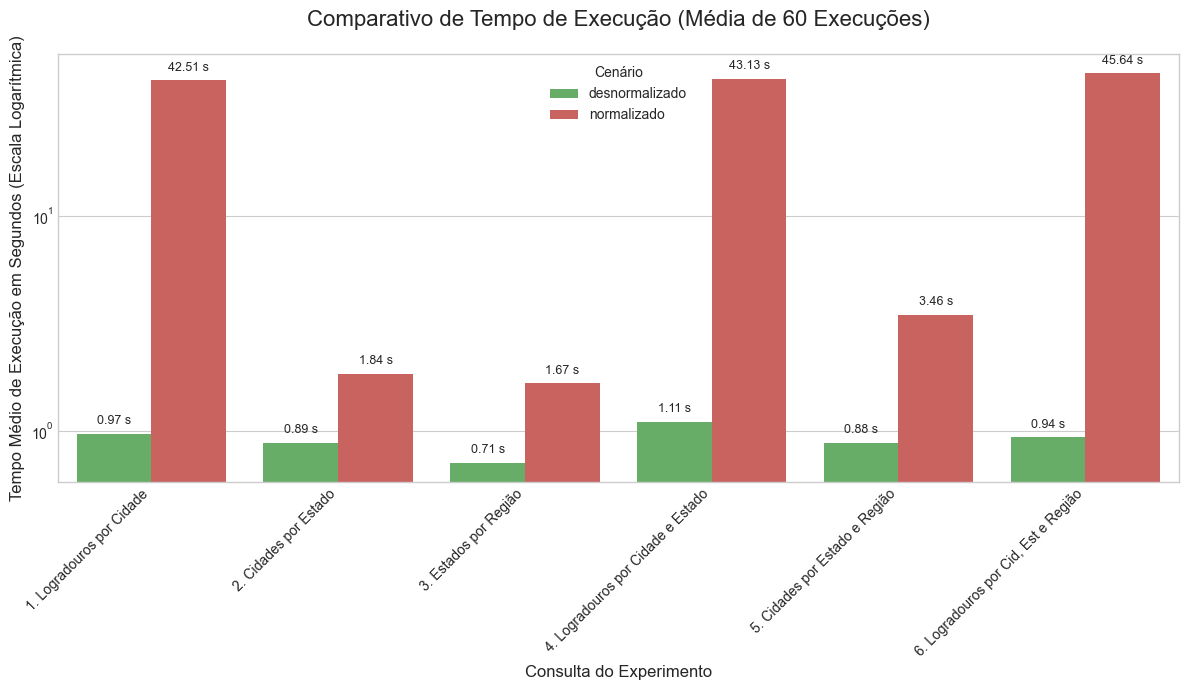

Gráfico de Bytes Lidos salvo em: 'results/final_analysis\grafico_comparativo_bytes_lidos.png'


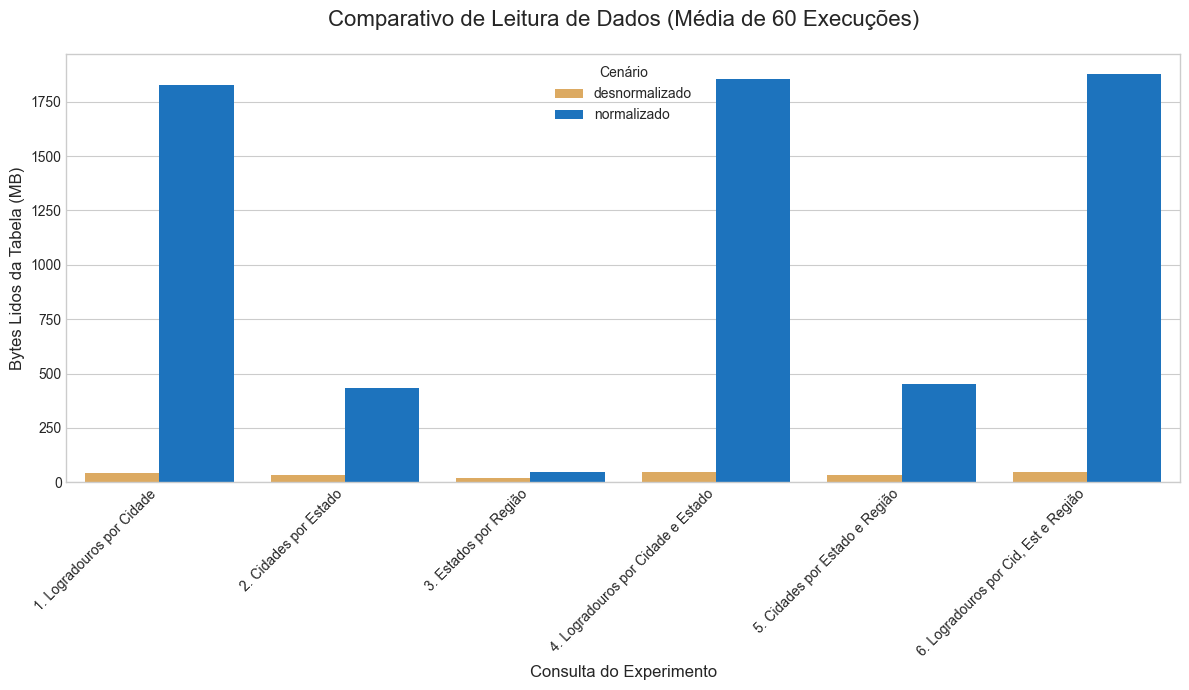

In [14]:
def generate_plots(summary_df, output_dir=OUTPUT_DIR):
    """
    Gera e salva os gráficos comparativos de Tempo de Execução e Bytes Lidos.
    """
    # Gráfico 1: Tempo de Execução (logarítmico)
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    
    sns.barplot(data=summary_df, x='Descricao', y='Tempo_Medio_s', hue='CENARIO', 
                palette={'normalizado': '#d9534f', 'desnormalizado': '#5cb85c'}, ax=ax)
    
    ax.set_yscale('log') # Escala logarítmica é essencial aqui
    ax.set_title('Comparativo de Tempo de Execução (Média de 60 Execuções)', fontsize=16, pad=20)
    ax.set_ylabel('Tempo Médio de Execução em Segundos (Escala Logarítmica)', fontsize=12)
    ax.set_xlabel('Consulta do Experimento', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')
    ax.legend(title='Cenário')
    
    # Adicionar rótulos de dados
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f} s", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)
    
    fig.tight_layout()
    chart_path1 = os.path.join(output_dir, 'grafico_comparativo_tempo.png')
    fig.savefig(chart_path1)
    print(f"Gráfico de Tempo de Execução salvo em: '{chart_path1}'")
    plt.show()

    # Gráfico 2: Bytes Lidos
    fig, ax = plt.subplots(figsize=(12, 7))
    
    sns.barplot(data=summary_df, x='Descricao', y='Bytes_Lidos_Medio_MB', hue='CENARIO',
                palette={'normalizado': '#0275d8', 'desnormalizado': '#f0ad4e'}, ax=ax)

    ax.set_title('Comparativo de Leitura de Dados (Média de 60 Execuções)', fontsize=16, pad=20)
    ax.set_ylabel('Bytes Lidos da Tabela (MB)', fontsize=12)
    ax.set_xlabel('Consulta do Experimento', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')
    ax.legend(title='Cenário')

    fig.tight_layout()
    chart_path2 = os.path.join(output_dir, 'grafico_comparativo_bytes_lidos.png')
    fig.savefig(chart_path2)
    print(f"Gráfico de Bytes Lidos salvo em: '{chart_path2}'")
    plt.show()

# Executa a geração de gráficos a partir dos dados agregados
if df_dados is not None:
    df_agg = df_dados.groupby(['Descricao', 'CENARIO']).agg(
        Tempo_Medio_s=('DURACAO_SEGUNDOS', 'mean'),
        Bytes_Lidos_Medio_MB=('BYTES_LIDOS_MB', 'mean')
    ).reset_index().sort_values('Descricao')
    
    generate_plots(df_agg)